# TC5: Signal and Image Processing; Assignment 4 denoising

The aim of this assignment is denoise a file by using spectral subtraction.

First, let's import the necessary packages.

In [16]:
from nt_toolbox.general import *
from nt_toolbox.signal import *
import pyroomacoustics as pra
from pyroomacoustics.denoise import SpectralSub

from IPython.display import Audio
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab as pyl
from scipy import signal
import seaborn as sns
sns.set()
sns.axes_style('white')

%matplotlib inline

## Part 1

Now, the first part of the assignment: Simulating a noisy version of the music using te noises at various SNR levels.

In [65]:
noisy_signal1_0, music, noise1, fs = pra.create_noisy_signal('./Data/music.wav', snr=0, noise_fp='./Data/noise1.wav')
noisy_signal1_1, music, noise1, _ = pra.create_noisy_signal('./Data/music.wav', snr=1, noise_fp='./Data/noise1.wav')
noisy_signal1_5, music, noise1, _ = pra.create_noisy_signal('./Data/music.wav', snr=5, noise_fp='./Data/noise1.wav')
noisy_signal1_10, music, noise1, _ = pra.create_noisy_signal('./Data/music.wav', snr=10, noise_fp='./Data/noise1.wav')
noisy_signal1_20, music, noise1, _ = pra.create_noisy_signal('./Data/music.wav', snr=20, noise_fp='./Data/noise1.wav')
noisy_signal2_0, music, noise2, _ = pra.create_noisy_signal('./Data/music.wav', snr=0, noise_fp='./Data/noise2.wav')
noisy_signal2_1, music, noise2, _ = pra.create_noisy_signal('./Data/music.wav', snr=1, noise_fp='./Data/noise2.wav')
noisy_signal2_5, music, noise2, _ = pra.create_noisy_signal('./Data/music.wav', snr=5, noise_fp='./Data/noise2.wav')
noisy_signal2_10, music, noise2, _ = pra.create_noisy_signal('./Data/music.wav', snr=10, noise_fp='./Data/noise2.wav')
noisy_signal2_20, music, noise2, _ = pra.create_noisy_signal('./Data/music.wav', snr=20, noise_fp='./Data/noise2.wav')
noisy_signal3_0, music, noise3, _ = pra.create_noisy_signal('./Data/music.wav', snr=0, noise_fp='./Data/noise3.wav')
noisy_signal3_1, music, noise3, _ = pra.create_noisy_signal('./Data/music.wav', snr=1, noise_fp='./Data/noise3.wav')
noisy_signal3_5, music, noise3, _ = pra.create_noisy_signal('./Data/music.wav', snr=5, noise_fp='./Data/noise3.wav')
noisy_signal3_10, music, noise3, _ = pra.create_noisy_signal('./Data/music.wav', snr=10, noise_fp='./Data/noise3.wav')
noisy_signal3_10, music, noise3, _ = pra.create_noisy_signal('./Data/music.wav', snr=20, noise_fp='./Data/noise3.wav')

In [49]:
Audio(noisy_signal1_20, rate=fs)

I decided to generate 5 versions of the music clip with each noise file, for a total of 15 sound files. The above field in the notebook can be used to play the file and see what it sounds like.

In [50]:
def spectrum_density(soundfile, fs):
    
    # Periodogram
    f, Pxx = signal.periodogram(soundfile, fs)
    fig, ax = plt.subplots(1, sharex=True, figsize=(10,4))
    plt.subplots_adjust(wspace =0.4, hspace =0)
    ax = plt.subplot(1,2,1)
    ax.semilogy(f, Pxx)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V^2/Hz]')
    ax.title.set_text('Periodogram')
    
    # Welsh method
    f, Pxx = signal.welch(soundfile, fs, nperseg=1024)
    ax = plt.subplot(1,2,2)
    ax.semilogy(f, Pxx)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V^2/Hz]')
    ax.title.set_text('Welsh Analysis')

    plt.show()

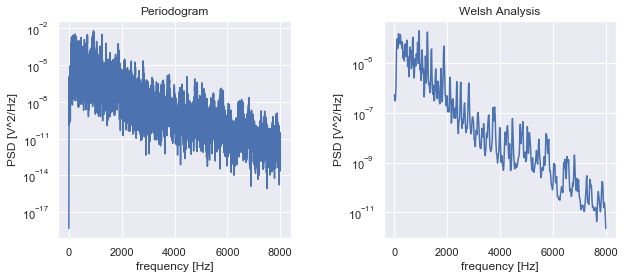

In [51]:
spectrum_density(music, fs)

The first plot here shows the periodogram of the original, non-noisy music file. The plot shows that the lower frequencies are more present in the music file than higher frequencies, and that the decrease in spectral density is linear in the log-scale of the y-axis in the plot. The Welch's method plot shows a similar characteristic.

The following plots show some of the generated noisy versions.

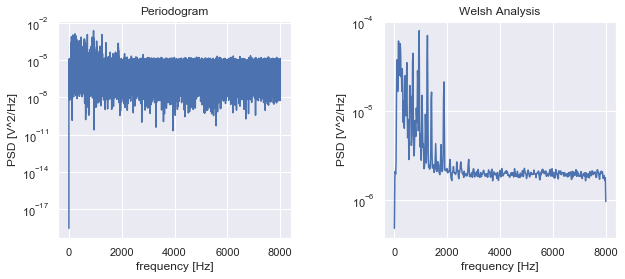

In [52]:
spectrum_density(noisy_signal1_1, fs_1)

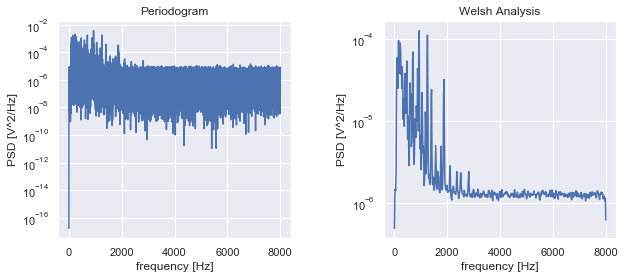

In [53]:
spectrum_density(noisy_signal1_5, fs_1)

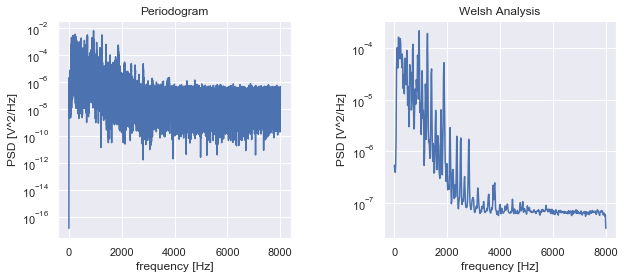

In [54]:
spectrum_density(noisy_signal1_20, fs_1)

As is visible from the plots, the spectral density is much more of a flat line on the log-scale y-axis when the SNR goes down.

## PART 2

Next up is the implementation of spectral subtraction for denoising.

In [158]:
def spectral_subtraction(noisy_sound, fs, orig_signal, nfft, nperseg=100, 
                         noverlap=None, plot=True):
    hop = nfft // 2
    db_reduc = 3
    lookback = 1
    beta = 3
    alpha = 1
    
    window = pra.hann(nfft, flag='asymmetric', length='full')
    stft = pra.transform.STFT(nfft, hop=hop, analysis_window=window, streaming=True)
    scnr = SpectralSub(nfft, db_reduc, lookback, beta, alpha)
    lookback_time = hop/fs * lookback    
    
    processed_audio = np.zeros(orig_signal.shape)
    n = 0
    while noisy_sound.shape[0] - n >= hop:

        stft.analysis(noisy_sound[n:(n+hop), ])
        gain_filt = scnr.compute_gain_filter(stft.X)

        processed_audio[n:n+hop, ] = stft.synthesis(gain_filt*stft.X)

        # update step
        n += hop  
    
    """
    Save and plot spectrogram
    """
    signal_norm = orig_signal / np.abs(orig_signal).max()
    
    if plot:
        min_val = -80
        max_val = -40
        plt.figure()
        plt.subplot(3, 1, 1)
        plt.specgram(noisy_sound[:n-hop], NFFT=256, Fs=fs,
                     vmin=min_val, vmax=max_val)
        plt.title('Noisy Signal')
        plt.subplot(3, 1, 2)
        plt.specgram(processed_audio[hop:n], NFFT=256, Fs=fs,
                     vmin=min_val, vmax=max_val)
        plt.title('Denoised Signal')
        plt.subplot(3, 1, 3)
        plt.specgram(signal_norm[:n-hop], NFFT=256, Fs=fs,
                     vmin=min_val, vmax=max_val)
        plt.title('Original Signal')
        plt.tight_layout(pad=0.5)
        plt.show()
                
    return processed_audio
        


## Part 3

Now, finally we will denoise the different versions of the noisy versions of the clean signal. This can be done for all the files using a for-loop, but for the sake of this assignment I deemed it illustrative enough to do it on only one example.

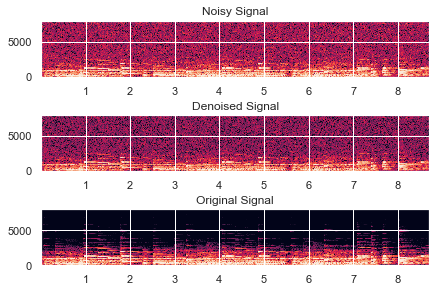

In [159]:
filtered_audio = spectral_subtraction(noisy_signal1_10, fs, music, nfft=1024)

In [160]:
Audio(noisy_signal1_10, rate=fs)

In [161]:
Audio(filtered_audio, rate=fs)

The two audio playbacks above show the difference between the audio pre-spectral subtraction and post-spectral subtraction. The difference is not super clear, but the piano sounds much less 'mushy' in the filtered_audio one, and this corresponds to a cleaner Denoised Signal graph above compared ot the Noisy Signal.

## Part 4

Discussing the parameters.

**Window:** For the shape of the window, 'Hann' was chosen due to its popularity and performance in the past.

**Lenght of window:** The common value of 1024 is used as the window length.

**hop/overlap:** For the overlap, the value of window length // 2 (50%) is chosen as this gave relatively smooth results and didn't take much time to compute.

**lookback:** How many frames we need to look back to for the noise floor estimation. 1 is enough in this case as a higher number did not seem to increase the performance.

**beta:** The factor to 'push' the gain filter vlaue closer to the dB reductino specified by db_reduc.
(https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.denoise.spectral_subtraction.html#pyroomacoustics.denoise.spectral_subtraction.SpectralSub)

**alpha:** The exponent factor to modify behaviour towards the db_reduc. Kept at the default of 1.